## RQ1

Index(['Testbed', 'Algorithm', 'Bug No.', 'Bug File', 'Bug category',
       'Real life bug?', 'Fuzzy Oracle Pass Rate', 'Human Oracle Pass Rate'],
      dtype='object')


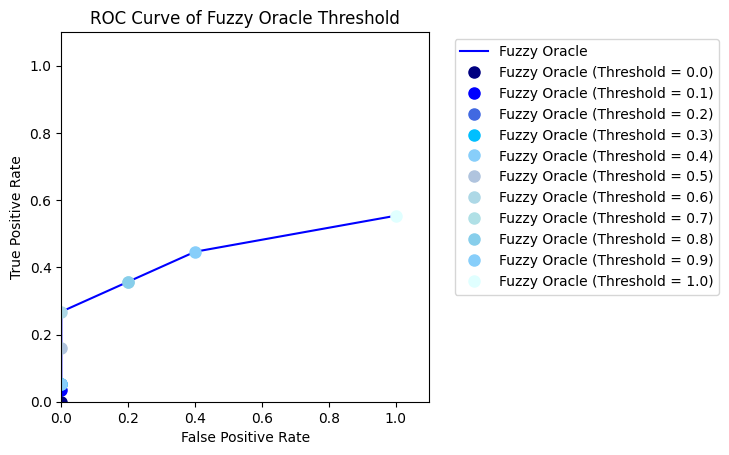

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
import matplotlib.pyplot as plt



# 定义计算评估指标的函数
def calculate_metrics(y_true, y_pred, threshold):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * tpr) / (precision + tpr) if (precision + tpr) > 0 else 0
    
    return [threshold, tpr, fpr, accuracy, precision, f1]

# 定义绘制ROC曲线的函数
def plot_roc_curve(fpr, tpr, thresholds, label, color, point_colors):
    plt.plot(fpr, tpr, label=label, color=color)
    
    # 选择要标注的阈值
    selected_thresholds = np.arange(0, 1.1, 0.1)
    
    for i, threshold in enumerate(selected_thresholds):
        idx = np.argmin(np.abs(thresholds - threshold))
        plt.plot(fpr[idx], tpr[idx], 'o', markersize=8, label=f'{label} (Threshold = {threshold:.1f})', color=point_colors[i])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


# 读取CSV文件
# data = pd.read_csv('Oracle Result 2_New.csv', skiprows=1, header=0)
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 定义阈值范围
thresholds = np.arange(0, 1.1, 0.1)

# 初始化结果数组
fuzzy_results = []

print(data.columns)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 对每个阈值进行分析
for threshold in thresholds:
    # 根据阈值计算Fuzzy Oracle的判定结果
    data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= threshold else 'Positive')
    
    # 计算评估指标
    fuzzy_metrics = calculate_metrics(data['True_Label'], data['Fuzzy_Prediction'], threshold)
    
    # 存储结果
    fuzzy_results.append(fuzzy_metrics)


# 将结果转换为DataFrame
fuzzy_df = pd.DataFrame(fuzzy_results, columns=['Threshold', 'TPR', 'FPR', 'Accuracy', 'Precision', 'F1'])

# 定义阈值点的颜色
fuzzy_point_colors = ['navy', 'blue', 'royalblue', 'deepskyblue', 'lightskyblue', 'lightsteelblue', 'lightblue', 'powderblue', 'skyblue', 'lightskyblue', 'lightcyan', 'paleturquoise']

# 绘制ROC曲线
plot_roc_curve(fuzzy_df['FPR'], fuzzy_df['TPR'], fuzzy_df['Threshold'], 'Fuzzy Oracle', 'blue', fuzzy_point_colors)

plt.title('ROC Curve of Fuzzy Oracle Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.7)

plt.xlim(0, 1.1)  # X轴固定在0-1范围
plt.ylim(0, 1.1)  # Y轴固定在0-1范围
plt.show()


# 计算AUC值
fuzzy_auc = auc(fuzzy_df['FPR'], fuzzy_df['TPR'])

# print(f"Fuzzy Oracle AUC: {fuzzy_auc:.2f}")


theta_oracle = 0.7

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

# 根据阈值计算Fuzzy Oracle和Human Oracle的判定结果
data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= theta_oracle else 'Positive')
data['Human_Prediction'] = data['Human Oracle Pass Rate'].apply(lambda x: 'Negative' if x > 0.5 else 'Positive')

# 定义计算评估指标的函数 - 修复F1计算问题
def calculate_metrics(y_true, y_pred):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # if precision + recall > 0:
    #     f1 = 2 * (precision * recall) / (precision + recall)
    # else:
    #     f1 = 0
    
    return [accuracy, precision, recall, f1]

# 定义计算混淆矩阵的函数
def calculate_confusion_matrix(y_true, y_pred):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    return tp, fp, tn, fn

# 初始化存储结果的字典
fuzzy_metrics = {}
human_metrics = {}
fuzzy_confusion = {}  # 用于存储环境的混淆矩阵
human_confusion = {}  # 用于存储环境的混淆矩阵
fuzzy_algo_confusion = {}  # 用于存储算法的混淆矩阵
human_algo_confusion = {}  # 用于存储算法的混淆矩阵

# 获取不同的Environment和Algorithm
environments = data['Testbed'].unique()
algorithms = data['Algorithm'].unique()
bug_categories = ['Updating network', 'Training', 'Model', 'Exploring the environment']

for env in environments:
    env_fuzzy_data = pd.DataFrame()
    env_human_data = pd.DataFrame()
    
    for algo in algorithms:
        env_algo_data = data[(data['Testbed'] == env) & (data['Algorithm'] == algo)]
        
        if len(env_algo_data) == 0:
            continue
        
        fuzzy_results = calculate_metrics(env_algo_data['True_Label'], env_algo_data['Fuzzy_Prediction'])
        fuzzy_metrics[f"{env} - {algo}"] = fuzzy_results
        
        human_results = calculate_metrics(env_algo_data['True_Label'], env_algo_data['Human_Prediction'])
        human_metrics[f"{env} - {algo}"] = human_results
        
        env_fuzzy_data = pd.concat([env_fuzzy_data, env_algo_data[['True_Label', 'Fuzzy_Prediction']]])
        env_human_data = pd.concat([env_human_data, env_algo_data[['True_Label', 'Human_Prediction']]])
    
    # 计算环境的混淆矩阵
    if not env_fuzzy_data.empty:
        tp, fp, tn, fn = calculate_confusion_matrix(env_fuzzy_data['True_Label'], env_fuzzy_data['Fuzzy_Prediction'])
        fuzzy_confusion[env] = (tp, fp, tn, fn)
    
    if not env_human_data.empty:
        tp, fp, tn, fn = calculate_confusion_matrix(env_human_data['True_Label'], env_human_data['Human_Prediction'])
        human_confusion[env] = (tp, fp, tn, fn)

for algo in algorithms:
    algo_data = data[data['Algorithm'] == algo]
    
    if not algo_data.empty:
        # 计算Fuzzy Oracle
        fuzzy_results = calculate_metrics(algo_data['True_Label'], algo_data['Fuzzy_Prediction'])
        fuzzy_metrics[algo] = fuzzy_results
        
        # 计算Human Oracle
        human_results = calculate_metrics(algo_data['True_Label'], algo_data['Human_Prediction'])
        human_metrics[algo] = human_results
        
        # 计算算法的混淆矩阵
        tp, fp, tn, fn = calculate_confusion_matrix(algo_data['True_Label'], algo_data['Fuzzy_Prediction'])
        fuzzy_algo_confusion[algo] = (tp, fp, tn, fn)
        
        tp, fp, tn, fn = calculate_confusion_matrix(algo_data['True_Label'], algo_data['Human_Prediction'])
        human_algo_confusion[algo] = (tp, fp, tn, fn)

# 计算Bug类别的平均指标
for category in bug_categories:
    category_data = data[data['Bug category'] == category]
    
    if not category_data.empty:
        fuzzy_results = calculate_metrics(category_data['True_Label'], category_data['Fuzzy_Prediction'])
        human_results = calculate_metrics(category_data['True_Label'], category_data['Human_Prediction'])
        
        fuzzy_metrics[category] = fuzzy_results
        human_metrics[category] = human_results

# 按环境和oracle分组
print("\nPerformance by Oracle and Environment")
print("------------------------------------")
print(f"{'Oracle':<20} {'Testbed':<25} {'TP':<6} {'FP':<6} {'TN':<6} {'FN':<6}")
print("------------------------------------")

for env in environments:
    if env in fuzzy_confusion:
        tp, fp, tn, fn = fuzzy_confusion[env]
        print(f"{'Fuzzy Oracle':<20} {env:<25} {tp:<6} {fp:<6} {tn:<6} {fn:<6}")
    
    if env in human_confusion:
        tp, fp, tn, fn = human_confusion[env]
        print(f"{'Human Oracle':<20} {env:<25} {tp:<6} {fp:<6} {tn:<6} {fn:<6}")

print("------------------------------------")

# 按算法和oracle分组
print("\nPerformance by Algorithm and Oracle")
print("------------------------------------")
print(f"{'Oracle':<20} {'Algorithm':<15} {'TP':<6} {'FP':<6} {'TN':<6} {'FN':<6}")
print("------------------------------------")

# 打印Fuzzy Oracle的算法结果
first_fuzzy = True
for algo in algorithms:
    if algo in fuzzy_algo_confusion:
        tp, fp, tn, fn = fuzzy_algo_confusion[algo]
        oracle_name = 'Fuzzy Oracle' if first_fuzzy else ''
        print(f"{oracle_name:<20} {algo:<15} {tp:<6} {fp:<6} {tn:<6} {fn:<6}")
        first_fuzzy = False

# 打印Human Oracle的算法结果
first_human = True
for algo in algorithms:
    if algo in human_algo_confusion:
        tp, fp, tn, fn = human_algo_confusion[algo]
        oracle_name = 'Human Oracle' if first_human else ''
        print(f"{oracle_name:<20} {algo:<15} {tp:<6} {fp:<6} {tn:<6} {fn:<6}")
        first_human = False

print("------------------------------------")



Performance by Oracle and Environment
------------------------------------
Oracle               Testbed                   TP     FP     TN     FN    
------------------------------------
Fuzzy Oracle         Frozen Lake               6      0      3      30    
Human Oracle         Frozen Lake               23     1      2      13    
Fuzzy Oracle         Mountaincar Continuous    9      0      2      11    
Human Oracle         Mountaincar Continuous    8      0      2      12    
------------------------------------

Performance by Algorithm and Oracle
------------------------------------
Oracle               Algorithm       TP     FP     TN     FN    
------------------------------------
Fuzzy Oracle         A2C             8      0      2      10    
                     DQN             4      0      1      11    
                     PPO             3      0      2      20    
Human Oracle         A2C             8      0      2      10    
                     DQN             13

Detailed Metrics Calculation:

--- Frozen Lake - A2C ---
Fuzzy Oracle: Accuracy=0.20, Precision=1.00, Recall=0.11, F1=0.20
Human Oracle: Accuracy=0.50, Precision=1.00, Recall=0.44, F1=0.62

--- Frozen Lake - DQN ---
Fuzzy Oracle: Accuracy=0.31, Precision=1.00, Recall=0.27, F1=0.42
Human Oracle: Accuracy=0.81, Precision=0.93, Recall=0.87, F1=0.90

--- Frozen Lake - PPO ---
Fuzzy Oracle: Accuracy=0.15, Precision=1.00, Recall=0.08, F1=0.15
Human Oracle: Accuracy=0.54, Precision=1.00, Recall=0.50, F1=0.67

--- Frozen Lake ---
Fuzzy Oracle: Accuracy=0.23, Precision=1.00, Recall=0.17, F1=0.29
Human Oracle: Accuracy=0.64, Precision=0.96, Recall=0.64, F1=0.77

--- Mountaincar Continuous - A2C ---
Fuzzy Oracle: Accuracy=0.80, Precision=1.00, Recall=0.78, F1=0.88
Human Oracle: Accuracy=0.50, Precision=1.00, Recall=0.44, F1=0.62

--- Mountaincar Continuous - PPO ---
Fuzzy Oracle: Accuracy=0.25, Precision=1.00, Recall=0.18, F1=0.31
Human Oracle: Accuracy=0.42, Precision=1.00, Recall=0.36, F1=0.53


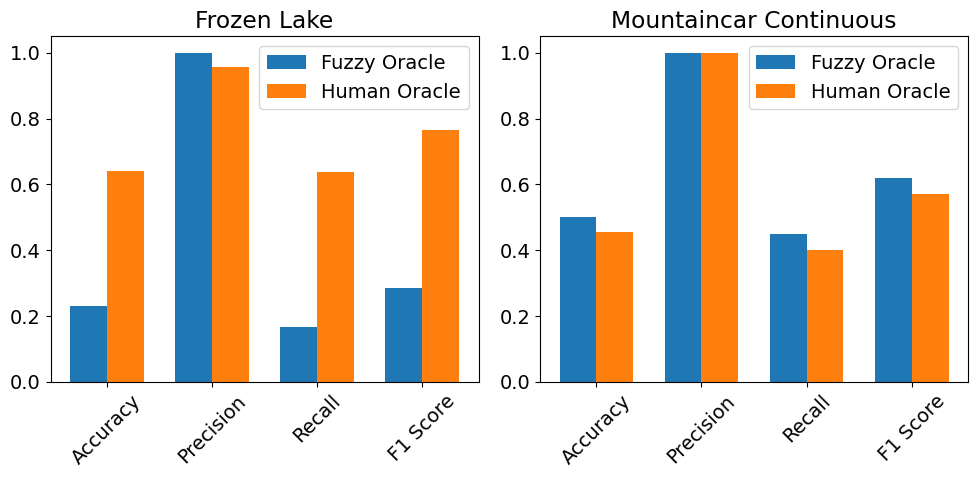

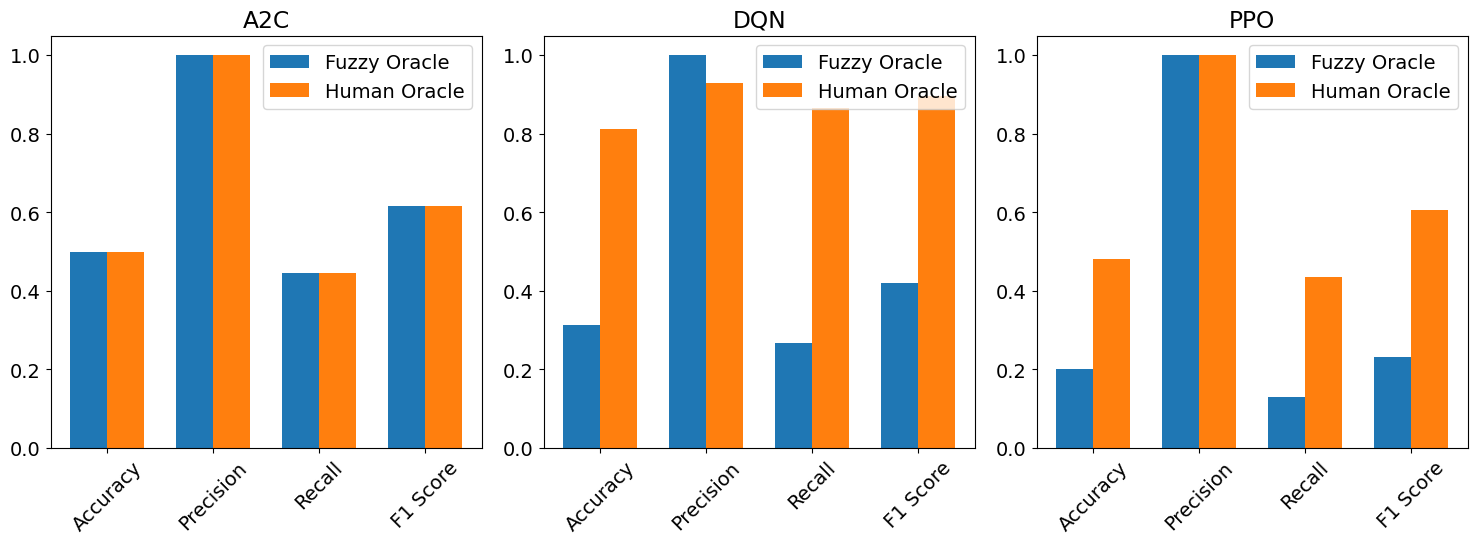


Fuzzy Oracle Metrics Summary:
Frozen Lake - A2C: Accuracy=0.20, Precision=1.00, Recall=0.11, F1=0.20
Frozen Lake - DQN: Accuracy=0.31, Precision=1.00, Recall=0.27, F1=0.42
Frozen Lake - PPO: Accuracy=0.15, Precision=1.00, Recall=0.08, F1=0.15
Frozen Lake: Accuracy=0.23, Precision=1.00, Recall=0.17, F1=0.29
Mountaincar Continuous - A2C: Accuracy=0.80, Precision=1.00, Recall=0.78, F1=0.88
Mountaincar Continuous - PPO: Accuracy=0.25, Precision=1.00, Recall=0.18, F1=0.31
Mountaincar Continuous: Accuracy=0.50, Precision=1.00, Recall=0.45, F1=0.62
A2C: Accuracy=0.50, Precision=1.00, Recall=0.44, F1=0.62
DQN: Accuracy=0.31, Precision=1.00, Recall=0.27, F1=0.42
PPO: Accuracy=0.20, Precision=1.00, Recall=0.13, F1=0.23

Human Oracle Metrics Summary:
Frozen Lake - A2C: Accuracy=0.50, Precision=1.00, Recall=0.44, F1=0.62
Frozen Lake - DQN: Accuracy=0.81, Precision=0.93, Recall=0.87, F1=0.90
Frozen Lake - PPO: Accuracy=0.54, Precision=1.00, Recall=0.50, F1=0.67
Frozen Lake: Accuracy=0.64, Precisio

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取CSV文件
data = pd.read_csv('Oracle Result (Slope as test oracle).csv', skiprows=1, header=0)

# 获取真实标签
data['True_Label'] = data['Bug No.'].apply(lambda x: 'Negative' if x == 'bug-free' else 'Positive')

data['Fuzzy_Prediction'] = data['Fuzzy Oracle Pass Rate'].apply(lambda x: 'Negative' if x >= theta_oracle else 'Positive')
data['Human_Prediction'] = data['Human Oracle Pass Rate'].apply(lambda x: 'Negative' if x > 0.5 else 'Positive')

def calculate_metrics(y_true, y_pred):
    tp = sum((y_true == 'Positive') & (y_pred == 'Positive'))
    tn = sum((y_true == 'Negative') & (y_pred == 'Negative'))
    fp = sum((y_true == 'Negative') & (y_pred == 'Positive'))
    fn = sum((y_true == 'Positive') & (y_pred == 'Negative'))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    

    # if precision + recall > 0:
    #     f1 = 2 * (precision * recall) / (precision + recall)
    # else:
    #     f1 = 0
    
    return [accuracy, precision, recall, f1]

# 初始化存储结果的字典
fuzzy_metrics = {}
human_metrics = {}

# 获取不同的Environment和Algorithm
environments = data['Testbed'].unique()
algorithms = data['Algorithm'].unique()
bug_categories = ['Updating network', 'Training', 'Model', 'Exploring the environment']

for env in environments:
    env_fuzzy_data = pd.DataFrame()
    env_human_data = pd.DataFrame()
    
    for algo in algorithms:
        env_algo_data = data[(data['Testbed'] == env) & (data['Algorithm'] == algo)]
        
        if len(env_algo_data) == 0:
            continue
        
        fuzzy_results = calculate_metrics(env_algo_data['True_Label'], env_algo_data['Fuzzy_Prediction'])
        fuzzy_metrics[f"{env} - {algo}"] = fuzzy_results
        
        human_results = calculate_metrics(env_algo_data['True_Label'], env_algo_data['Human_Prediction'])
        human_metrics[f"{env} - {algo}"] = human_results
        
        env_fuzzy_data = pd.concat([env_fuzzy_data, env_algo_data[['True_Label', 'Fuzzy_Prediction']]])
        env_human_data = pd.concat([env_human_data, env_algo_data[['True_Label', 'Human_Prediction']]])
    
    if not env_fuzzy_data.empty:
        fuzzy_metrics[env] = calculate_metrics(env_fuzzy_data['True_Label'], env_fuzzy_data['Fuzzy_Prediction'])
    if not env_human_data.empty:
        human_metrics[env] = calculate_metrics(env_human_data['True_Label'], env_human_data['Human_Prediction'])

for algo in algorithms:
    algo_data = data[data['Algorithm'] == algo]
    
    if not algo_data.empty:
        # 计算Fuzzy Oracle的
        fuzzy_results = calculate_metrics(algo_data['True_Label'], algo_data['Fuzzy_Prediction'])
        fuzzy_metrics[algo] = fuzzy_results
        
        # 计算Human Oracle
        human_results = calculate_metrics(algo_data['True_Label'], algo_data['Human_Prediction'])
        human_metrics[algo] = human_results

# Bug类别
for category in bug_categories:
    category_data = data[data['Bug category'] == category]
    
    if not category_data.empty:
        fuzzy_results = calculate_metrics(category_data['True_Label'], category_data['Fuzzy_Prediction'])
        human_results = calculate_metrics(category_data['True_Label'], category_data['Human_Prediction'])
        
        fuzzy_metrics[category] = fuzzy_results
        human_metrics[category] = human_results

print("Detailed Metrics Calculation:")
for key in fuzzy_metrics:
    if key in human_metrics:
        print(f"\n--- {key} ---")
        print(f"Fuzzy Oracle: Accuracy={fuzzy_metrics[key][0]:.2f}, Precision={fuzzy_metrics[key][1]:.2f}, Recall={fuzzy_metrics[key][2]:.2f}, F1={fuzzy_metrics[key][3]:.2f}")
        print(f"Human Oracle: Accuracy={human_metrics[key][0]:.2f}, Precision={human_metrics[key][1]:.2f}, Recall={human_metrics[key][2]:.2f}, F1={human_metrics[key][3]:.2f}")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# 设置字体大小
plt.rcParams.update({'font.size': 14})

# 1. 绘制不同环境下的性能比较
fig, axs = plt.subplots(1, len(environments), figsize=(5*len(environments), 5))
if len(environments) == 1:
    axs = [axs]  # 确保单个环境时也能正确处理

for i, env in enumerate(environments):
    if env in fuzzy_metrics and env in human_metrics:
        x = np.arange(len(metrics))
        width = 0.35
        
        axs[i].bar(x - width/2, fuzzy_metrics[env], width, label='Fuzzy Oracle')
        axs[i].bar(x + width/2, human_metrics[env], width, label='Human Oracle')
        axs[i].set_title(env)
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(metrics, rotation=45)
        axs[i].set_ylim(0, 1.05)
        axs[i].legend()

plt.tight_layout()
plt.savefig('environment_comparison.png', dpi=300)
plt.show()

# 2. 绘制不同算法下的性能比较
if len(algorithms) > 0:
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(max(2, len(algorithms)//2 + 1), min(3, len(algorithms)))
    
    for i, algo in enumerate(algorithms):
        if algo in fuzzy_metrics and algo in human_metrics:
            row = i // min(3, len(algorithms))
            col = i % min(3, len(algorithms))
            ax = fig.add_subplot(gs[row, col])
            
            x = np.arange(len(metrics))
            width = 0.35
            
            ax.bar(x - width/2, fuzzy_metrics[algo], width, label='Fuzzy Oracle')
            ax.bar(x + width/2, human_metrics[algo], width, label='Human Oracle')
            ax.set_title(algo)
            ax.set_xticks(x)
            ax.set_xticklabels(metrics, rotation=45)
            ax.set_ylim(0, 1.05)
            ax.legend()

    plt.tight_layout()
    plt.savefig('algorithm_comparison.png', dpi=300)
    plt.show()

# 3. 绘制不同Bug类别的性能比较
# if len(bug_categories) > 0:
#     fig, axs = plt.subplots(1, len(bug_categories), figsize=(5*len(bug_categories), 5))
#     if len(bug_categories) == 1:
#         axs = [axs]
    
#     for i, category in enumerate(bug_categories):
#         if category in fuzzy_metrics and category in human_metrics:
#             x = np.arange(len(metrics))
#             width = 0.35
            
#             axs[i].bar(x - width/2, fuzzy_metrics[category], width, label='Fuzzy Oracle')
#             axs[i].bar(x + width/2, human_metrics[category], width, label='Human Oracle')
#             axs[i].set_title(category)
#             axs[i].set_xticks(x)
#             axs[i].set_xticklabels(metrics, rotation=45)
#             axs[i].set_ylim(0, 1.05)
#             axs[i].legend()
#     plt.tight_layout()
#     plt.savefig('bug_category_comparison.png', dpi=300)
#     plt.show()

# 打印计算结果
print("\nFuzzy Oracle Metrics Summary:")
for key, value in fuzzy_metrics.items():
    print(f"{key}: Accuracy={value[0]:.2f}, Precision={value[1]:.2f}, Recall={value[2]:.2f}, F1={value[3]:.2f}")
    
print("\nHuman Oracle Metrics Summary:")
for key, value in human_metrics.items():
    print(f"{key}: Accuracy={value[0]:.2f}, Precision={value[1]:.2f}, Recall={value[2]:.2f}, F1={value[3]:.2f}")